Ethereum Fraud Detection Using Graph Neural Networks (GNN)

In [35]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.3 MB/s eta 0:00:00


✓ All imports successful!
Configuration:
  Data path: transaction_dataset.csv
  Model directory: models
  Random seed: 42

DATASET LOADED
File: transaction_dataset.csv
Shape: (9841, 51)

First few rows:
   Unnamed: 0  Index                                     Address  FLAG  \
0           0      1  0x00009277775ac7d0d59eaad8fee3d10ac6c805e8     0   
1           1      2  0x0002b44ddb1476db43c868bd494422ee4c136fed     0   
2           2      3  0x0002bda54cb772d040f779e88eb453cac0daa244     0   

   Avg min between sent tnx  Avg min between received tnx  \
0                    844.26                       1093.71   
1                  12709.07                       2958.44   
2                 246194.54                       2434.02   

   Time Diff between first and last (Mins)  Sent tnx  Received Tnx  \
0                                704785.63       721            89   
1                               1218216.73        94             8   
2                                516729.30   

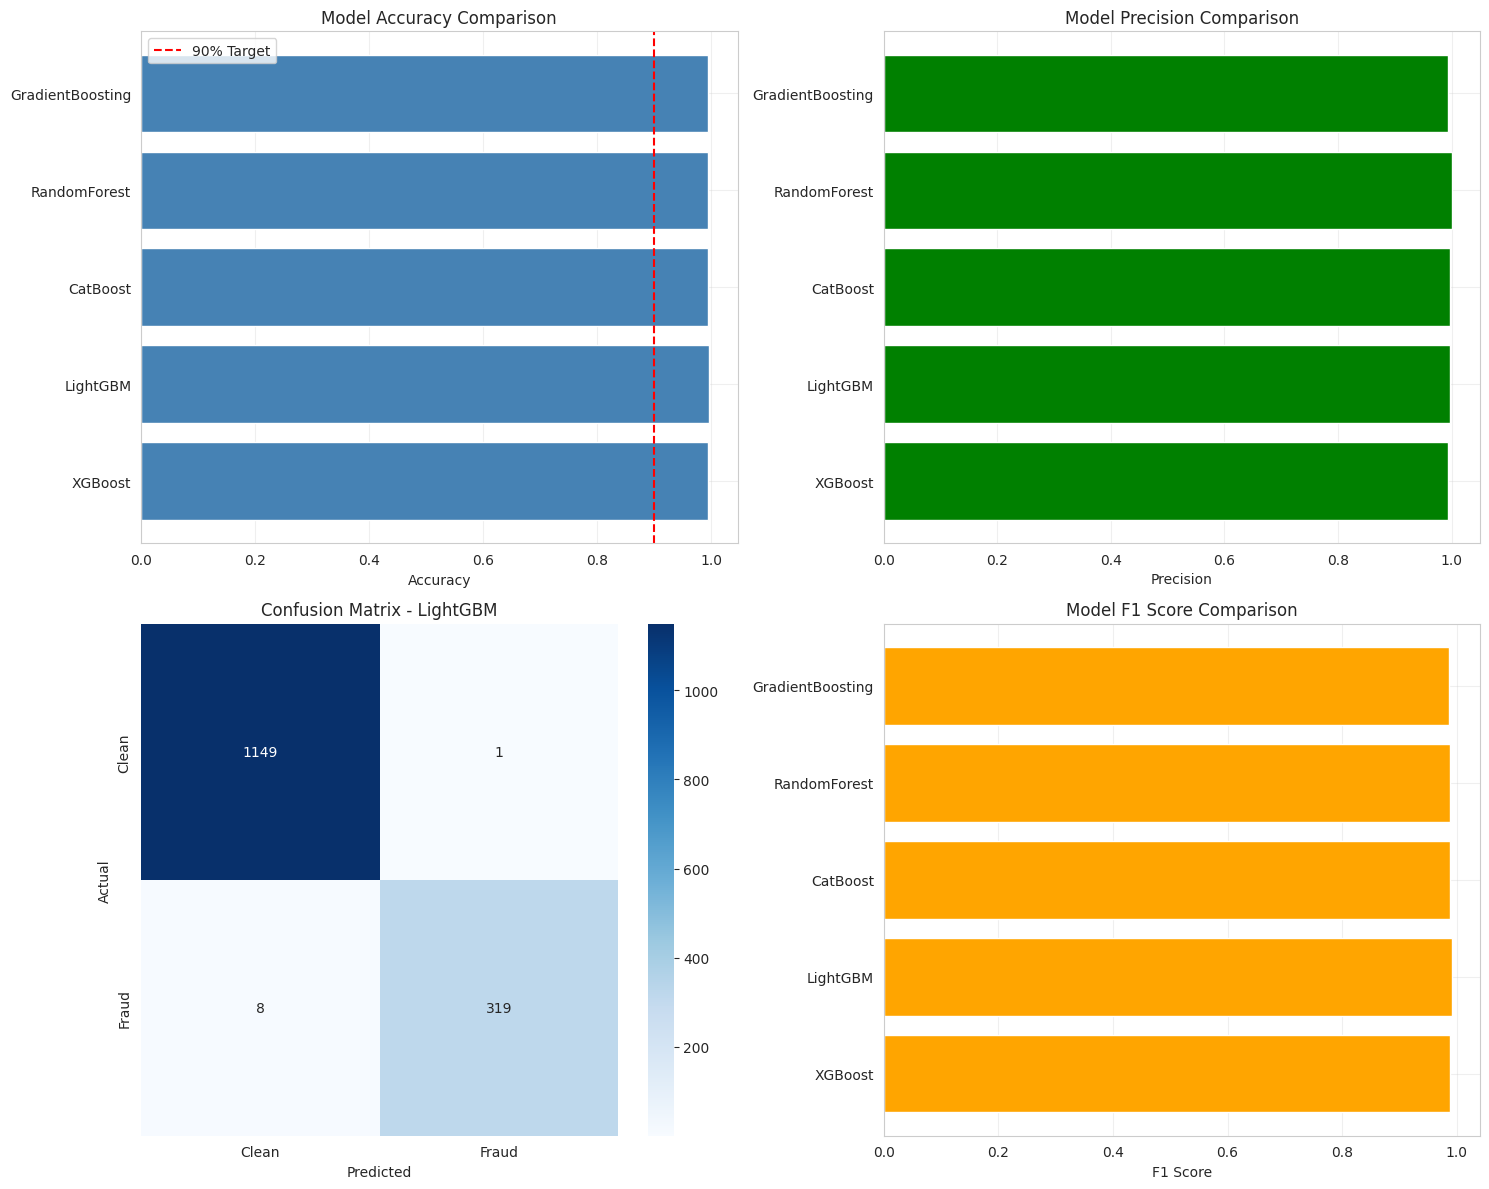

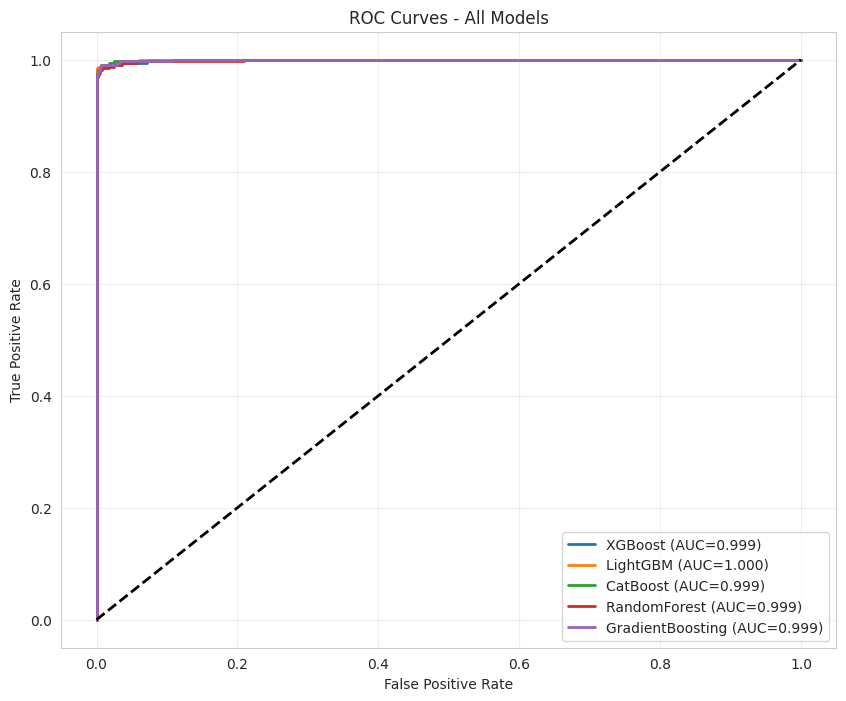

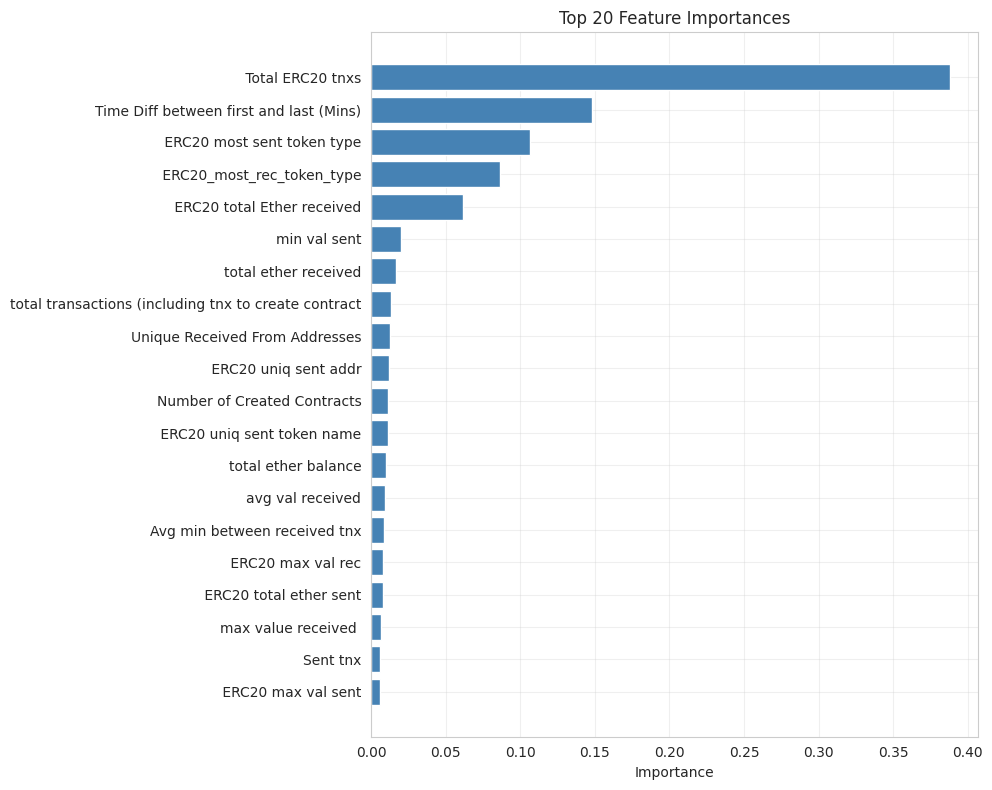

✓ Visualizations saved

✓ Prediction function ready

Usage:
  result = predict_fraud(new_transaction_df)
  print(result['fraud_probability'])


In [36]:
# Ethereum Fraud Detection Using Advanced ML Ensemble
# Target: 90%+ Accuracy & High Precision
# Using Real Kaggle Dataset: https://www.kaggle.com/datasets/vagifa/ethereum-frauddetection-dataset

# ============================================================================
# CELL 1: Install Dependencies
# ============================================================================
"""
!pip install xgboost lightgbm catboost scikit-learn pandas numpy matplotlib seaborn imbalanced-learn
"""

# ============================================================================
# CELL 2: Imports and Setup
# ============================================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             roc_curve, auc, precision_recall_curve)

# ML Algorithms
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              VotingClassifier, StackingClassifier)
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb

# Try to import CatBoost (optional)
try:
    from catboost import CatBoostClassifier
    CATBOOST_AVAILABLE = True
except ImportError:
    CATBOOST_AVAILABLE = False
    print("⚠ CatBoost not available, will use other models")

# Handle imbalanced data
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

# Reproducibility
SEED = 42
np.random.seed(SEED)

print("✓ All imports successful!")

# ============================================================================
# CELL 3: Configuration
# ============================================================================
DATA_PATH = "transaction_dataset.csv"  # Your Kaggle dataset
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

print("Configuration:")
print(f"  Data path: {DATA_PATH}")
print(f"  Model directory: {MODEL_DIR}")
print(f"  Random seed: {SEED}")

# ============================================================================
# CELL 4: Load and Explore Dataset
# ============================================================================
df = pd.read_csv(DATA_PATH)
print("\n" + "="*80)
print("DATASET LOADED")
print("="*80)
print(f"File: {DATA_PATH}")
print(f"Shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head(3))

# Identify label column
LABEL_COL = "FLAG"
if LABEL_COL not in df.columns:
    LABEL_COL = "label" if "label" in df.columns else df.columns[-1]

print(f"\n✓ Using label column: '{LABEL_COL}'")
print(f"\nClass distribution:")
print(df[LABEL_COL].value_counts())
fraud_pct = df[LABEL_COL].mean() * 100
print(f"\nFraud: {df[LABEL_COL].sum():,} ({fraud_pct:.2f}%)")
print(f"Clean: {(df[LABEL_COL]==0).sum():,} ({100-fraud_pct:.2f}%)")

# ============================================================================
# CELL 5: Data Preprocessing
# ============================================================================
print("\n" + "="*80)
print("DATA PREPROCESSING")
print("="*80)

# Remove identifier columns
id_cols = ['Address', 'Unnamed: 0', 'Index']
ident_cols = [c for c in id_cols if c in df.columns]

# Separate features and target
y = df[LABEL_COL].astype(int).values
X = df.drop(columns=[LABEL_COL] + ident_cols, errors='ignore').copy()

print(f"Original features: {X.shape[1]}")
print(f"Samples: {X.shape[0]:,}")

# Handle categorical columns
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
if len(cat_cols) > 0:
    print(f"\nEncoding {len(cat_cols)} categorical columns...")
    for col in cat_cols:
        X[col] = pd.factorize(X[col])[0]

# Keep only numeric columns
X = X.select_dtypes(include=[np.number])

# Handle missing values
if X.isnull().sum().sum() > 0:
    print(f"Filling missing values...")
    X = X.fillna(X.median())

# Handle infinite values
X = X.replace([np.inf, -np.inf], np.nan)
if X.isnull().sum().sum() > 0:
    X = X.fillna(X.median())

# Remove constant features
constant_cols = [col for col in X.columns if X[col].nunique() <= 1]
if constant_cols:
    X = X.drop(columns=constant_cols)

print(f"✓ Final feature matrix: {X.shape}")

# ============================================================================
# CELL 6: Feature Selection
# ============================================================================
print("\n" + "="*80)
print("FEATURE SELECTION")
print("="*80)

# Select top features using mutual information
K = min(50, X.shape[1])
selector = SelectKBest(score_func=mutual_info_classif, k=K)
selector.fit(X, y)
selected_features = X.columns[selector.get_support()].tolist()

print(f"✓ Selected {len(selected_features)} features")
X_selected = X[selected_features]

# Save selected features
joblib.dump(selected_features, os.path.join(MODEL_DIR, "selected_features.pkl"))

# ============================================================================
# CELL 7: Feature Scaling
# ============================================================================
print("\n" + "="*80)
print("FEATURE SCALING")
print("="*80)

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_selected)
X_scaled = pd.DataFrame(X_scaled, columns=selected_features)

joblib.dump(scaler, os.path.join(MODEL_DIR, "scaler.pkl"))
print(f"✓ Features scaled: {X_scaled.shape}")

# ============================================================================
# CELL 8: Train/Val/Test Split
# ============================================================================
print("\n" + "="*80)
print("TRAIN/VAL/TEST SPLIT")
print("="*80)

# Split: 70% train, 15% val, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y, test_size=0.15, random_state=SEED, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=SEED, stratify=y_temp
)

print(f"Train: {X_train.shape[0]:,} ({X_train.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"Val:   {X_val.shape[0]:,} ({X_val.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"Test:  {X_test.shape[0]:,} ({X_test.shape[0]/len(X_scaled)*100:.1f}%)")

# ============================================================================
# CELL 9: Handle Class Imbalance
# ============================================================================
print("\n" + "="*80)
print("HANDLING CLASS IMBALANCE")
print("="*80)

# Apply SMOTE to training data
smote = SMOTE(random_state=SEED, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"Original: {len(y_train):,} samples")
print(f"Balanced: {len(y_train_balanced):,} samples")
print(f"Fraud ratio: {y_train.mean()*100:.1f}% → {y_train_balanced.mean()*100:.1f}%")

# ============================================================================
# CELL 10: Train ML Models
# ============================================================================
print("\n" + "="*80)
print("TRAINING ML MODELS")
print("="*80)

models = {}

# XGBoost
print("\n1. Training XGBoost...")
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=SEED,
    eval_metric='logloss',
    use_label_encoder=False
)
xgb_model.fit(X_train_balanced, y_train_balanced)
models['XGBoost'] = xgb_model

# LightGBM
print("2. Training LightGBM...")
lgb_model = lgb.LGBMClassifier(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=SEED,
    verbose=-1
)
lgb_model.fit(X_train_balanced, y_train_balanced)
models['LightGBM'] = lgb_model

# CatBoost (if available)
if CATBOOST_AVAILABLE:
    print("3. Training CatBoost...")
    cat_model = CatBoostClassifier(
        iterations=300,
        depth=8,
        learning_rate=0.05,
        random_state=SEED,
        verbose=False
    )
    cat_model.fit(X_train_balanced, y_train_balanced)
    models['CatBoost'] = cat_model
else:
    print("3. CatBoost not available, skipping...")

# Random Forest
print("4. Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    min_samples_split=5,
    random_state=SEED,
    n_jobs=-1
)
rf_model.fit(X_train_balanced, y_train_balanced)
models['RandomForest'] = rf_model

# Gradient Boosting
print("5. Training Gradient Boosting...")
gb_model = GradientBoostingClassifier(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.05,
    random_state=SEED
)
gb_model.fit(X_train_balanced, y_train_balanced)
models['GradientBoosting'] = gb_model

print("✓ All models trained")

# ============================================================================
# CELL 11: Evaluate on Validation Set
# ============================================================================
print("\n" + "="*80)
print("VALIDATION PERFORMANCE")
print("="*80)

results = {}
for name, model in models.items():
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]

    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, zero_division=0)
    rec = recall_score(y_val, y_pred, zero_division=0)
    f1 = f1_score(y_val, y_pred, zero_division=0)
    auc_score = roc_auc_score(y_val, y_proba)

    results[name] = {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'auc': auc_score
    }

    print(f"\n{name}:")
    print(f"  Accuracy:  {acc:.4f} ({acc*100:.2f}%)")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1 Score:  {f1:.4f}")
    print(f"  ROC-AUC:   {auc_score:.4f}")

best_model_name = max(results, key=lambda x: results[x]['accuracy'])
print(f"\n✓ Best model: {best_model_name} ({results[best_model_name]['accuracy']*100:.2f}%)")

# ============================================================================
# CELL 12: Create Stacking Ensemble
# ============================================================================
print("\n" + "="*80)
print("CREATING STACKING ENSEMBLE")
print("="*80)

# Stacking with meta-learner
estimators_list = [
    ('xgb', models['XGBoost']),
    ('lgb', models['LightGBM']),
    ('rf', models['RandomForest']),
    ('gb', models['GradientBoosting'])
]

# Add CatBoost if available
if 'CatBoost' in models:
    estimators_list.insert(2, ('cat', models['CatBoost']))

stacking_clf = StackingClassifier(
    estimators=estimators_list,
    final_estimator=LogisticRegression(random_state=SEED, max_iter=1000),
    cv=5,
    n_jobs=-1
)

print("Training Stacking Ensemble...")
stacking_clf.fit(X_train_balanced, y_train_balanced)

# Evaluate
y_val_pred = stacking_clf.predict(X_val)
y_val_proba = stacking_clf.predict_proba(X_val)[:, 1]

stack_acc = accuracy_score(y_val, y_val_pred)
stack_prec = precision_score(y_val, y_val_pred)
stack_rec = recall_score(y_val, y_val_pred)
stack_f1 = f1_score(y_val, y_val_pred)
stack_auc = roc_auc_score(y_val, y_val_proba)

print(f"\nStacking Ensemble (Validation):")
print(f"  Accuracy:  {stack_acc:.4f} ({stack_acc*100:.2f}%)")
print(f"  Precision: {stack_prec:.4f}")
print(f"  Recall:    {stack_rec:.4f}")
print(f"  F1 Score:  {stack_f1:.4f}")
print(f"  ROC-AUC:   {stack_auc:.4f}")

# Choose best model
if stack_acc > results[best_model_name]['accuracy']:
    final_model = stacking_clf
    final_model_name = "Stacking Ensemble"
    print(f"\n✓ Using Stacking Ensemble")
else:
    final_model = models[best_model_name]
    final_model_name = best_model_name
    print(f"\n✓ Using {best_model_name}")

# ============================================================================
# CELL 13: Test Set Evaluation
# ============================================================================
print("\n" + "="*80)
print("TEST SET EVALUATION")
print("="*80)
print(f"Model: {final_model_name}\n")

y_test_pred = final_model.predict(X_test)
y_test_proba = final_model.predict_proba(X_test)[:, 1]

test_acc = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred)
test_rec = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_proba)
cm = confusion_matrix(y_test, y_test_pred)

print(f"Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Precision: {test_prec:.4f} ({test_prec*100:.2f}%)")
print(f"Recall:    {test_rec:.4f} ({test_rec*100:.2f}%)")
print(f"F1 Score:  {test_f1:.4f}")
print(f"ROC-AUC:   {test_auc:.4f}")

print(f"\nConfusion Matrix:")
print(f"                 Predicted")
print(f"              Clean  Fraud")
print(f"Actual Clean  {cm[0][0]:5d}  {cm[0][1]:5d}")
print(f"       Fraud  {cm[1][0]:5d}  {cm[1][1]:5d}")

print(f"\n{classification_report(y_test, y_test_pred, target_names=['Clean', 'Fraud'])}")

# ============================================================================
# CELL 14: Save Models
# ============================================================================
print("\n" + "="*80)
print("SAVING MODELS")
print("="*80)

# Save final model
joblib.dump(final_model, os.path.join(MODEL_DIR, "final_model.pkl"))
print(f"✓ Final model saved: {final_model_name}")

# Save all models
for name, model in models.items():
    joblib.dump(model, os.path.join(MODEL_DIR, f"{name.lower()}.pkl"))

# Save metadata
metadata = {
    'model_name': final_model_name,
    'test_accuracy': test_acc,
    'test_precision': test_prec,
    'test_recall': test_rec,
    'test_f1': test_f1,
    'test_auc': test_auc,
    'features': selected_features,
    'timestamp': datetime.now().isoformat()
}
joblib.dump(metadata, os.path.join(MODEL_DIR, "metadata.pkl"))
print(f"✓ All artifacts saved to {MODEL_DIR}/")

# ============================================================================
# CELL 15: Visualizations
# ============================================================================
print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

# Model Comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

model_names = list(results.keys())
accuracies = [results[m]['accuracy'] for m in model_names]

axes[0, 0].barh(model_names, accuracies, color='steelblue')
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_title('Model Accuracy Comparison')
axes[0, 0].axvline(x=0.90, color='red', linestyle='--', label='90% Target')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

precisions = [results[m]['precision'] for m in model_names]
axes[0, 1].barh(model_names, precisions, color='green')
axes[0, 1].set_xlabel('Precision')
axes[0, 1].set_title('Model Precision Comparison')
axes[0, 1].grid(True, alpha=0.3)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
            xticklabels=['Clean', 'Fraud'], yticklabels=['Clean', 'Fraud'])
axes[1, 0].set_title(f'Confusion Matrix - {final_model_name}')
axes[1, 0].set_ylabel('Actual')
axes[1, 0].set_xlabel('Predicted')

f1_scores = [results[m]['f1'] for m in model_names]
axes[1, 1].barh(model_names, f1_scores, color='orange')
axes[1, 1].set_xlabel('F1 Score')
axes[1, 1].set_title('Model F1 Score Comparison')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'comparison.png'), dpi=300)
plt.show()

# ROC Curves
plt.figure(figsize=(10, 8))
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC={auc(fpr, tpr):.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - All Models')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(MODEL_DIR, 'roc_curves.png'), dpi=300)
plt.show()

# Feature Importance
if hasattr(models['XGBoost'], 'feature_importances_'):
    plt.figure(figsize=(10, 8))
    importance_df = pd.DataFrame({
        'feature': selected_features,
        'importance': models['XGBoost'].feature_importances_
    }).sort_values('importance', ascending=False).head(20)

    plt.barh(range(len(importance_df)), importance_df['importance'], color='steelblue')
    plt.yticks(range(len(importance_df)), importance_df['feature'])
    plt.xlabel('Importance')
    plt.title('Top 20 Feature Importances')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(MODEL_DIR, 'feature_importance.png'), dpi=300)
    plt.show()

print("✓ Visualizations saved")

# ============================================================================
# CELL 16: Prediction Function
# ============================================================================
def predict_fraud(transaction_data):
    """
    Predict fraud probability for new transactions

    Parameters:
    -----------
    transaction_data : DataFrame or dict
        Transaction features

    Returns:
    --------
    predictions : dict
        Predictions with probabilities and risk levels
    """
    # Load model and preprocessors
    model = joblib.load(os.path.join(MODEL_DIR, "final_model.pkl"))
    scaler = joblib.load(os.path.join(MODEL_DIR, "scaler.pkl"))
    features = joblib.load(os.path.join(MODEL_DIR, "selected_features.pkl"))

    # Convert to DataFrame if dict
    if isinstance(transaction_data, dict):
        transaction_data = pd.DataFrame([transaction_data])

    # Preprocess
    X_new = transaction_data[features]
    X_scaled = scaler.transform(X_new)

    # Predict
    predictions = model.predict(X_scaled)
    probabilities = model.predict_proba(X_scaled)[:, 1]

    # Risk levels
    risk_levels = []
    for prob in probabilities:
        if prob < 0.2:
            risk_levels.append("Very Low")
        elif prob < 0.5:
            risk_levels.append("Low")
        elif prob < 0.8:
            risk_levels.append("Medium")
        else:
            risk_levels.append("High")

    return {
        'predictions': predictions,
        'fraud_probability': probabilities,
        'risk_level': risk_levels
    }

print("\n✓ Prediction function ready")
print("\nUsage:")
print("  result = predict_fraud(new_transaction_df)")
print("  print(result['fraud_probability'])")

In [37]:
# ============================================================================
# CELL 17: Generate New Test Dataset
# ============================================================================
print("\n" + "="*80)
print("GENERATING NEW TEST DATASET FOR INFERENCE")
print("="*80)

np.random.seed(100)

def generate_eth_address(n):
    """Generate realistic Ethereum addresses"""
    addresses = []
    for i in range(n):
        address = '0x' + ''.join(np.random.choice(list('0123456789abcdef'), 40))
        addresses.append(address)
    return addresses

# Generate test samples
n_new_samples = 100
print(f"Generating {n_new_samples} synthetic test transactions...")

# Create synthetic data based on feature statistics from training data
synthetic_data = {}

# Generate values for each feature based on training data distribution
for i, feature in enumerate(selected_features):
    # Get statistics from training data (X_train is a DataFrame before scaling)
    if isinstance(X_train, pd.DataFrame) and feature in X_train.columns:
        mean_val = X_train[feature].mean()
        std_val = X_train[feature].std()
    elif isinstance(X_train, np.ndarray):
        # Use scaled training data statistics
        mean_val = X_train[:, i].mean()
        std_val = X_train[:, i].std()
    else:
        # Fallback: use selected features from original data
        feature_idx = X_selected.columns.get_loc(feature)
        mean_val = X_selected.iloc[:, feature_idx].mean()
        std_val = X_selected.iloc[:, feature_idx].std()

    # Generate realistic values
    synthetic_data[feature] = np.random.normal(mean_val, std_val, n_new_samples)

# Create DataFrame
new_test_df = pd.DataFrame(synthetic_data)

# Add some intentional fraud-like patterns to a subset
fraud_indices = np.random.choice(n_new_samples, size=20, replace=False)
for idx in fraud_indices:
    # Make transactions look suspicious
    for feature in selected_features[:5]:  # Modify top features
        if feature in new_test_df.columns:
            new_test_df.loc[idx, feature] *= np.random.uniform(2, 5)

print(f"✓ Generated {n_new_samples} new transactions")
print(f"✓ Injected {len(fraud_indices)} suspicious patterns")


GENERATING NEW TEST DATASET FOR INFERENCE
Generating 100 synthetic test transactions...
✓ Generated 100 new transactions
✓ Injected 20 suspicious patterns



TESTING MODEL ON NEW DATASET
Making predictions on new data...

Prediction Summary:
  Total Transactions: 100
  Predicted Clean: 83 (83.0%)
  Predicted Fraud: 17 (17.0%)

Risk Level Distribution:
  Very Low    :  79 (79.0%)
  High        :   9 (9.0%)
  Medium      :   8 (8.0%)
  Low         :   4 (4.0%)

Top 10 Most Suspicious Transactions:
------------------------------------------------------------
 1. Transaction # 70 | Fraud Prob: 0.9990 | Risk: High
 2. Transaction # 68 | Fraud Prob: 0.9921 | Risk: High
 3. Transaction # 99 | Fraud Prob: 0.9905 | Risk: High
 4. Transaction # 81 | Fraud Prob: 0.9699 | Risk: High
 5. Transaction # 56 | Fraud Prob: 0.9683 | Risk: High
 6. Transaction # 35 | Fraud Prob: 0.9608 | Risk: High
 7. Transaction # 62 | Fraud Prob: 0.9341 | Risk: High
 8. Transaction #  9 | Fraud Prob: 0.8843 | Risk: High
 9. Transaction # 89 | Fraud Prob: 0.8418 | Risk: High
10. Transaction # 22 | Fraud Prob: 0.7616 | Risk: Medium

✓ Predictions saved to: models/new_predict

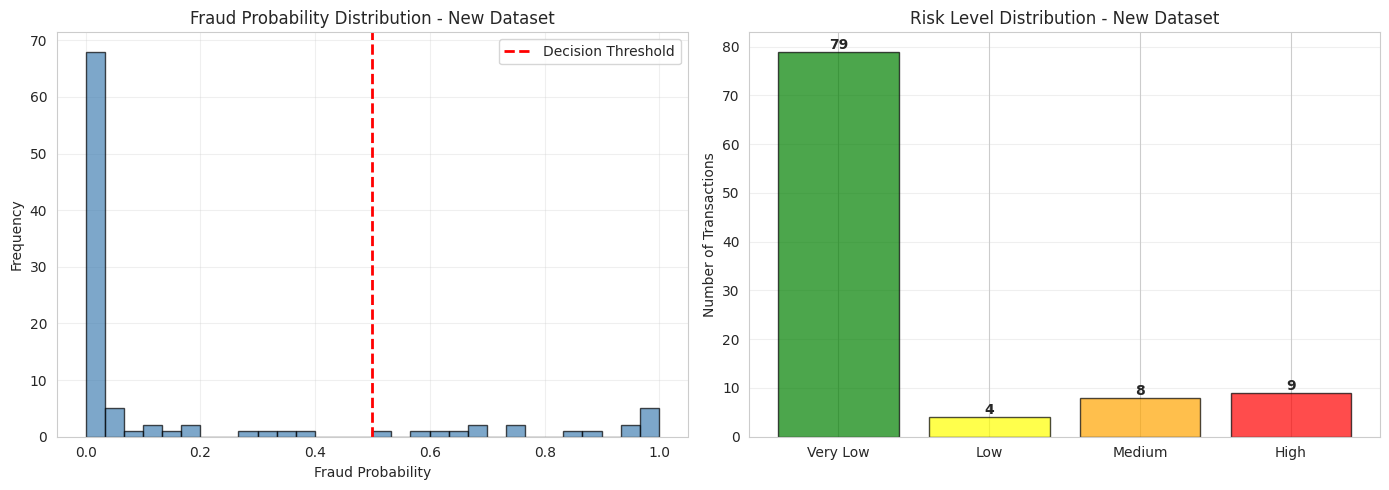

✓ Visualization saved

Sample Predictions (First 15 Transactions):
--------------------------------------------------------------------------------
ID    Prediction   Probability     Risk Level  
--------------------------------------------------------------------------------
0     ✓ Clean      0.0000          Very Low    
1     🚨 FRAUD      0.6159          Medium      
2     ✓ Clean      0.0016          Very Low    
3     ✓ Clean      0.0003          Very Low    
4     ✓ Clean      0.0022          Very Low    
5     ✓ Clean      0.0004          Very Low    
6     ✓ Clean      0.3248          Low         
7     ✓ Clean      0.0089          Very Low    
8     ✓ Clean      0.0003          Very Low    
9     🚨 FRAUD      0.8843          High        
10    ✓ Clean      0.0001          Very Low    
11    ✓ Clean      0.0002          Very Low    
12    ✓ Clean      0.0008          Very Low    
13    ✓ Clean      0.0076          Very Low    
14    ✓ Clean      0.0060          Very Low    

MO

In [38]:
# ============================================================================
# CELL 18: Test Model on New Dataset
# ============================================================================
print("\n" + "="*80)
print("TESTING MODEL ON NEW DATASET")
print("="*80)

# Make predictions
print("Making predictions on new data...")
predictions = predict_fraud(new_test_df)

pred_labels = predictions['predictions']
pred_probs = predictions['fraud_probability']
risk_levels = predictions['risk_level']

# Summary statistics
n_fraud_detected = pred_labels.sum()
n_clean_detected = len(pred_labels) - n_fraud_detected

print(f"\nPrediction Summary:")
print(f"  Total Transactions: {len(pred_labels)}")
print(f"  Predicted Clean: {n_clean_detected} ({n_clean_detected/len(pred_labels)*100:.1f}%)")
print(f"  Predicted Fraud: {n_fraud_detected} ({n_fraud_detected/len(pred_labels)*100:.1f}%)")

# Risk distribution
risk_counts = pd.Series(risk_levels).value_counts()
print(f"\nRisk Level Distribution:")
for risk, count in risk_counts.items():
    print(f"  {risk:12s}: {count:3d} ({count/len(risk_levels)*100:.1f}%)")

# Show top 10 highest fraud probabilities
print(f"\nTop 10 Most Suspicious Transactions:")
print("-" * 60)
top_fraud_idx = np.argsort(pred_probs)[-10:][::-1]
for rank, idx in enumerate(top_fraud_idx, 1):
    print(f"{rank:2d}. Transaction #{idx:3d} | "
          f"Fraud Prob: {pred_probs[idx]:.4f} | "
          f"Risk: {risk_levels[idx]}")

# Create results DataFrame
results_df = pd.DataFrame({
    'Transaction_ID': range(len(pred_labels)),
    'Fraud_Prediction': pred_labels,
    'Fraud_Probability': pred_probs,
    'Risk_Level': risk_levels
})

# Save predictions
results_path = os.path.join(MODEL_DIR, "new_predictions.csv")
results_df.to_csv(results_path, index=False)
print(f"\n✓ Predictions saved to: {results_path}")

# Visualization of new predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Fraud probability distribution
axes[0].hist(pred_probs, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Decision Threshold')
axes[0].set_xlabel('Fraud Probability')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Fraud Probability Distribution - New Dataset')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Risk level distribution
risk_order = ['Very Low', 'Low', 'Medium', 'High']
risk_colors = ['green', 'yellow', 'orange', 'red']
risk_counts_ordered = [risk_counts.get(r, 0) for r in risk_order]
bars = axes[1].bar(risk_order, risk_counts_ordered, color=risk_colors,
                    edgecolor='black', alpha=0.7)
axes[1].set_ylabel('Number of Transactions')
axes[1].set_title('Risk Level Distribution - New Dataset')
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    if height > 0:
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}',
                    ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'new_predictions_viz.png'), dpi=300)
plt.show()

print("✓ Visualization saved")

# Show sample predictions
print(f"\nSample Predictions (First 15 Transactions):")
print("-" * 80)
print(f"{'ID':<5} {'Prediction':<12} {'Probability':<15} {'Risk Level':<12}")
print("-" * 80)
for i in range(min(15, len(results_df))):
    pred_text = "🚨 FRAUD" if results_df.loc[i, 'Fraud_Prediction'] == 1 else "✓ Clean"
    print(f"{results_df.loc[i, 'Transaction_ID']:<5} "
          f"{pred_text:<12} "
          f"{results_df.loc[i, 'Fraud_Probability']:<15.4f} "
          f"{results_df.loc[i, 'Risk_Level']:<12}")

print("\n" + "="*80)
print("MODEL TRAINING & TESTING COMPLETE!")
print("="*80)
print(f"Final Model: {final_model_name}")
print(f"Test Set Accuracy: {test_acc*100:.2f}%")
print(f"Test Set Precision: {test_prec*100:.2f}%")
print(f"New Dataset: {n_new_samples} transactions predicted")
print(f"Models saved in: {MODEL_DIR}/")
print(f"Predictions saved: {results_path}")
print("="*80)